# PyTorch Custom Datasets

## Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## downloading custom dataset (food vision mini)

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## data preparation and exploration

In [3]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f" there are {len(filenames)} images and {len(dirnames)} directories in {dirpath}")

walk_through_dir(image_path)


 there are 0 images and 2 directories in data/pizza_steak_sushi
 there are 0 images and 3 directories in data/pizza_steak_sushi/train
 there are 75 images and 0 directories in data/pizza_steak_sushi/train/steak
 there are 78 images and 0 directories in data/pizza_steak_sushi/train/pizza
 there are 72 images and 0 directories in data/pizza_steak_sushi/train/sushi
 there are 0 images and 3 directories in data/pizza_steak_sushi/test
 there are 19 images and 0 directories in data/pizza_steak_sushi/test/steak
 there are 25 images and 0 directories in data/pizza_steak_sushi/test/pizza
 there are 31 images and 0 directories in data/pizza_steak_sushi/test/sushi


In [4]:
# setup train and test paths
train_dir=image_path/"train"

test_dir=image_path/"test"

Random image path: data/pizza_steak_sushi/train/steak/735441.jpg
Image class: steak
Image height: 512
Image width: 512


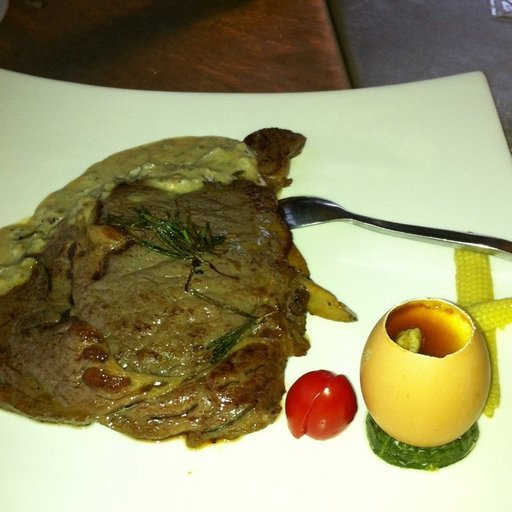

In [5]:
# visualize some images
from pathlib import Path
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

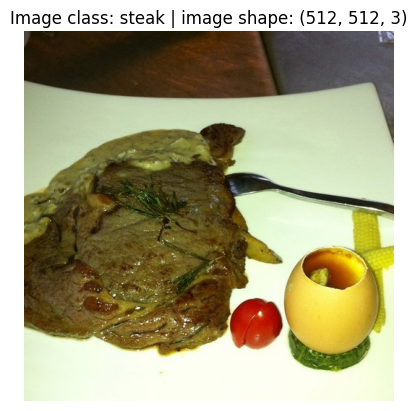

In [6]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)

#plot image
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | image shape: {img_as_array.shape}")
plt.axis(False)

## Transforming data

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
data_transform= transforms.Compose([
    #resize images
    transforms.Resize(size=(64, 64)),
    # flip images horizontally
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image into tensor
    transforms.ToTensor()
])


In [9]:
data_transform(img).shape

torch.Size([3, 64, 64])

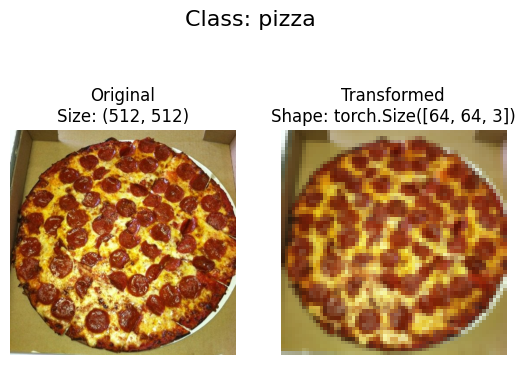

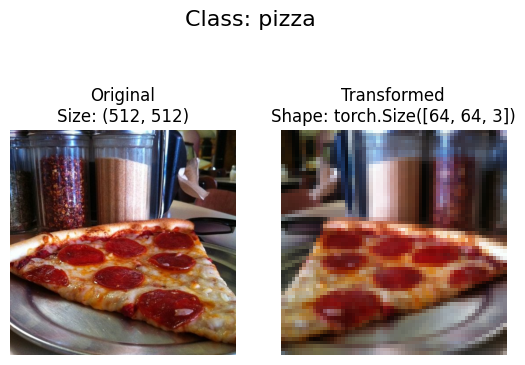

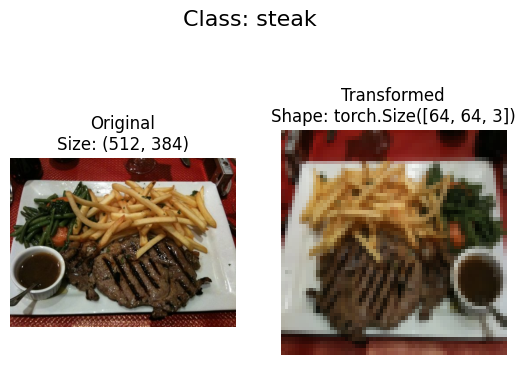

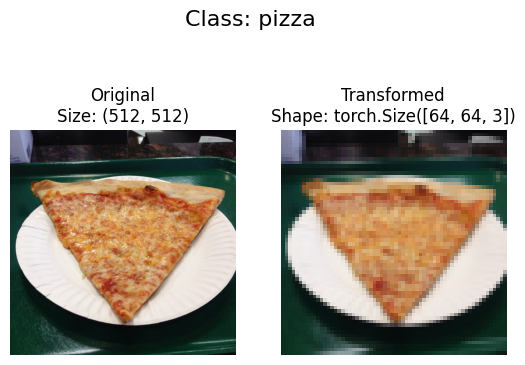

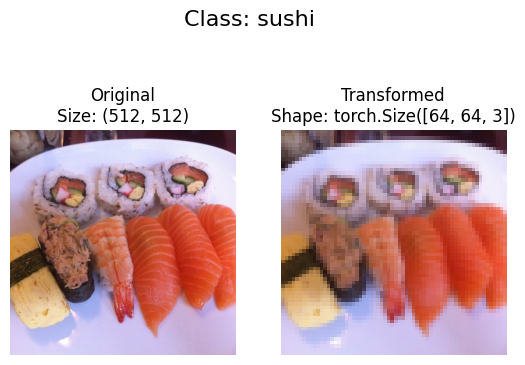

In [10]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=5,
                        seed=None)

## Loading images using ImageFolder

In [11]:
train_data=datasets.ImageFolder(train_dir, data_transform, target_transform=None)

test_data=datasets.ImageFolder(test_dir, data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
train_data.samples[:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

In [14]:
img, label=train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image Tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

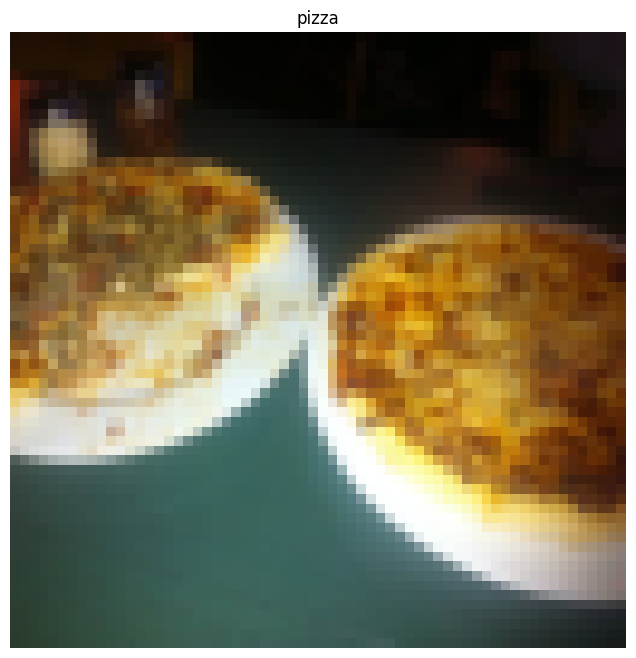

In [15]:
# rearrange order of dimensions (H W C)
img_permute=img.permute(1, 2, 0)

print(f"Original shape: {img.shape}")
print(f"Image permute: {img_permute.shape}")

#plot image
plt.figure(figsize=(10, 8))
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False)

## Turn train and test datasets into DataLoader

In [16]:
train_dataloader=DataLoader(train_data, batch_size=1, shuffle=True, num_workers=os.cpu_count())
test_dataloader=DataLoader(test_data, batch_size=1, shuffle=True, num_workers=os.cpu_count())

train_dataloader

In [17]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Creating a data-loading class (similar to ImageFolder)

In [18]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### create a function to get class_names based on directories

In [19]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

#get class names
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [20]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [21]:
classes, class_to_idx=find_classes(train_dir)
classes, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [22]:
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):
    #get all imag paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #setup transforms
    self.transform=transform
    #create classes and class_to_idx
    self.classes, self.class_to_idx= find_classes(targ_dir)
    #create function to load images
  def load_image(self, index: int) -> Image.Image:
    image_path=self.paths[index]
    return Image.open(image_path)

    #overwrite __len__() method:
  def __len__(self) -> int:
    return len(self.paths)

    # overwrite __getitem__() method
  def __getitem__(self, index: int) ->Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

      # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [23]:
# Create a transform
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
])

In [24]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [25]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ecf46917b80>,
 <__main__.ImageFolderCustom at 0x7ecf46a8b6a0>)

In [26]:
len(train_data), len(train_data_custom)

(225, 225)

In [27]:
len(test_data), len(test_data_custom)

(75, 75)

In [28]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [29]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [30]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [31]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

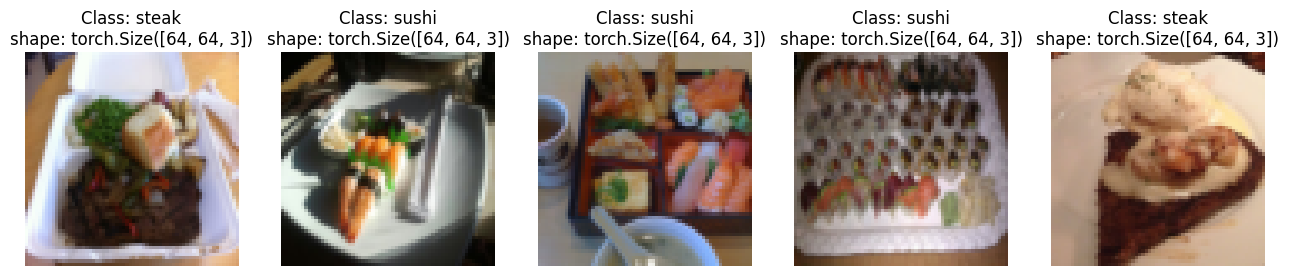

In [32]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

### Turn custom loaded images into DataLoader's


In [33]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ecf467c31c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ecf467c1900>)

## State of the art data augmentation using PyTorch Primitives (TrivialAugment)

In [34]:
train_transform=transforms.Compose([transforms.Resize(size=(224, 224)),
                                    transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                    transforms.ToTensor()])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [35]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1961025.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/214320.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2707522.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3727491.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/560503.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2324994.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2628106.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1615395.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2254705.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg')]

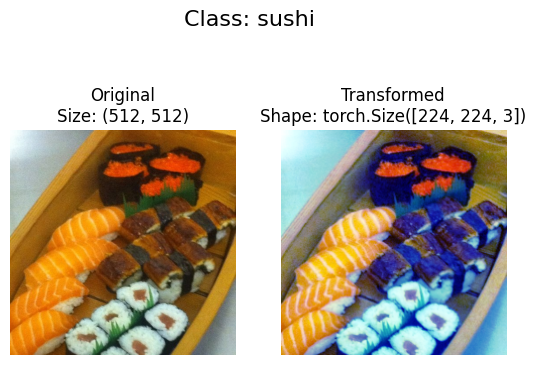

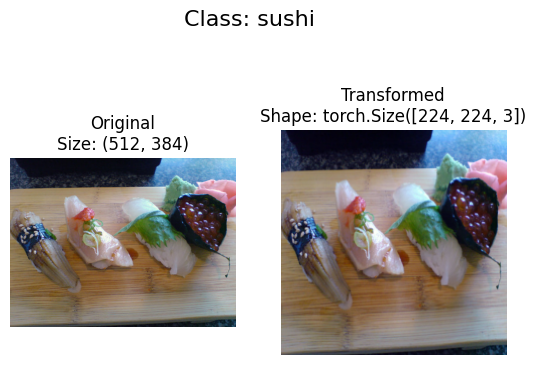

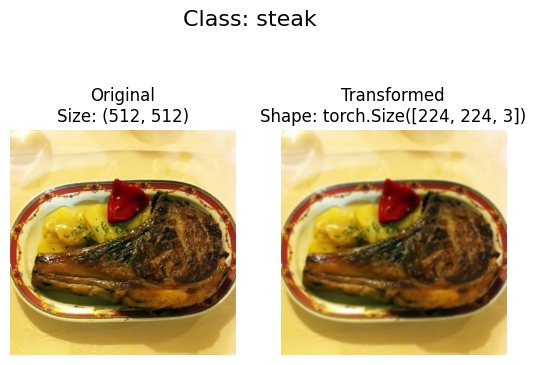

In [36]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

# Model 0: Baseline model (TinyVGG without data augmentation)

In [37]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

In [38]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

BATCH_SIZE=32

train_dataloader_simple=DataLoader(train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader_simple=DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [39]:
# create model 0 by subclassing nn.Module

class Model_0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.output_layer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )

  def forward(self, x):
    x=self.conv_block_1(x)
    x=self.conv_block_2(x)
    x=self.output_layer(x)

    return x

In [40]:
model_0=Model_0(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [41]:
#test model with single image
image_batch, label_batch=next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [42]:
model_0(image_batch.to(device))

tensor([[ 0.0244, -0.0182, -0.0205],
        [ 0.0332, -0.0148, -0.0219],
        [ 0.0341, -0.0198, -0.0212],
        [ 0.0182, -0.0163, -0.0164],
        [ 0.0272, -0.0230, -0.0238],
        [ 0.0282, -0.0182, -0.0206],
        [ 0.0232, -0.0244, -0.0247],
        [ 0.0214, -0.0210, -0.0208],
        [ 0.0318, -0.0213, -0.0267],
        [ 0.0197, -0.0178, -0.0196],
        [ 0.0241, -0.0160, -0.0215],
        [ 0.0262, -0.0164, -0.0227],
        [ 0.0211, -0.0198, -0.0200],
        [ 0.0242, -0.0253, -0.0219],
        [ 0.0264, -0.0175, -0.0226],
        [ 0.0284, -0.0208, -0.0218],
        [ 0.0286, -0.0233, -0.0272],
        [ 0.0295, -0.0263, -0.0208],
        [ 0.0191, -0.0180, -0.0168],
        [ 0.0266, -0.0247, -0.0236],
        [ 0.0270, -0.0220, -0.0263],
        [ 0.0261, -0.0184, -0.0232],
        [ 0.0330, -0.0220, -0.0245],
        [ 0.0196, -0.0230, -0.0248],
        [ 0.0315, -0.0218, -0.0235],
        [ 0.0270, -0.0245, -0.0264],
        [ 0.0216, -0.0209, -0.0230],
 

In [43]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
Model_0                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [44]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [45]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [46]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [47]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of model_0
model_0 = Model_0(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.2907
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0695 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0810 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0843 | Train acc: 0.3984 | Test loss: 1.0607 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5341
Total training time: 7.953 seconds


In [48]:
model_0_results

{'train_loss': [1.1063192486763,
  1.099800854921341,
  1.0868670642375946,
  1.0842746049165726,
  1.0662257075309753],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983266830444336,
  1.0694934924443562,
  1.080967386563619,
  1.06066890557607,
  1.0653901894887288],
 'test_acc': [0.29071969696969696,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5340909090909091]}

In [49]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

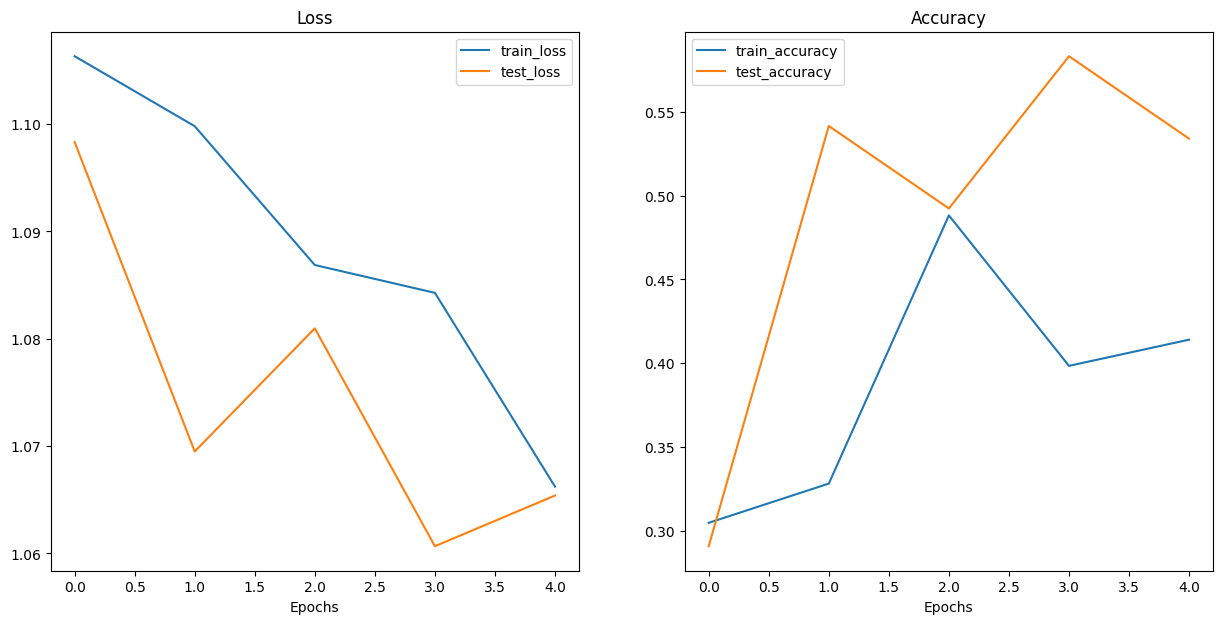

In [50]:
plot_loss_curves(model_0_results)

# Model 1: TinyVGG with data augmentation

In [51]:
from torchvision import transforms
train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])

test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()])

In [53]:
# create train and test datasets
train_dataset_augmented=datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)
test_dataset=datasets.ImageFolder(root=test_dir, transform=test_transform_simple)

train_dataset_augmented, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [54]:
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented=DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [55]:
# Construct Model 1:
model_1=Model_0(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_1

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [57]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS=5
#train loop
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1260 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0713 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1260 | Train acc: 0.3047 | Test loss: 1.1584 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0857 | Train acc: 0.4219 | Test loss: 1.1550 | Test acc: 0.3125
Total training time: 5.607 seconds


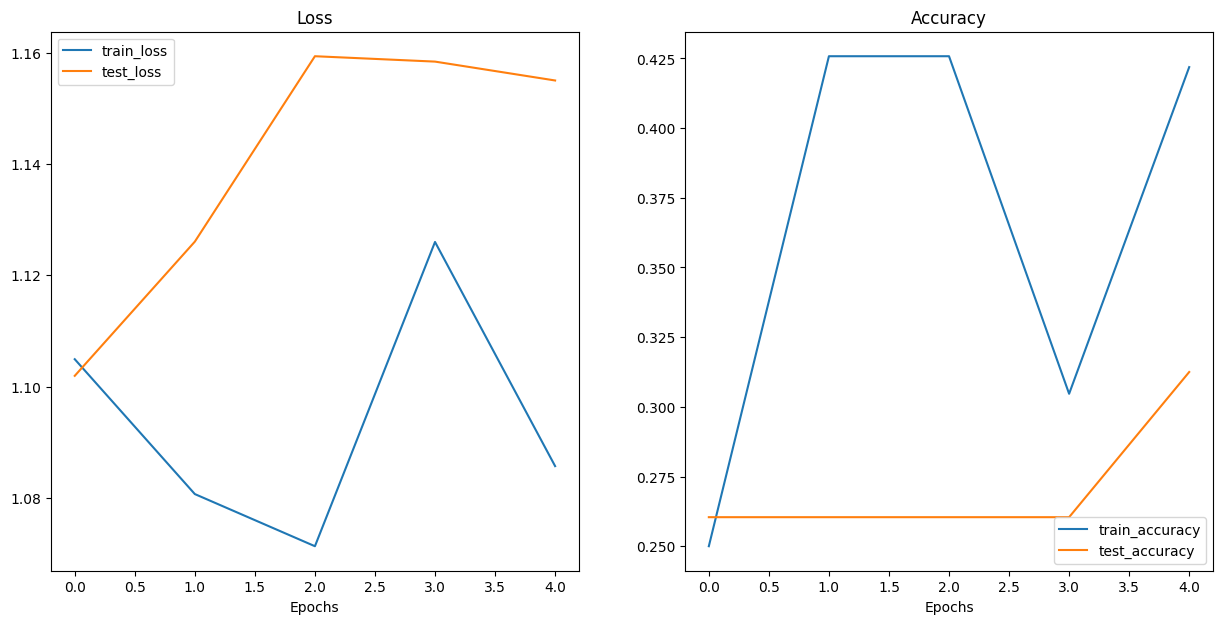

In [58]:
plot_loss_curves(model_1_results)

## Compare model results

In [60]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098327,0.290720
1,1.099801,0.328125,1.069493,0.541667
2,1.086867,0.488281,1.080967,0.492424
3,1.084275,0.398438,1.060669,0.583333
4,1.066226,0.414062,1.065390,0.534091


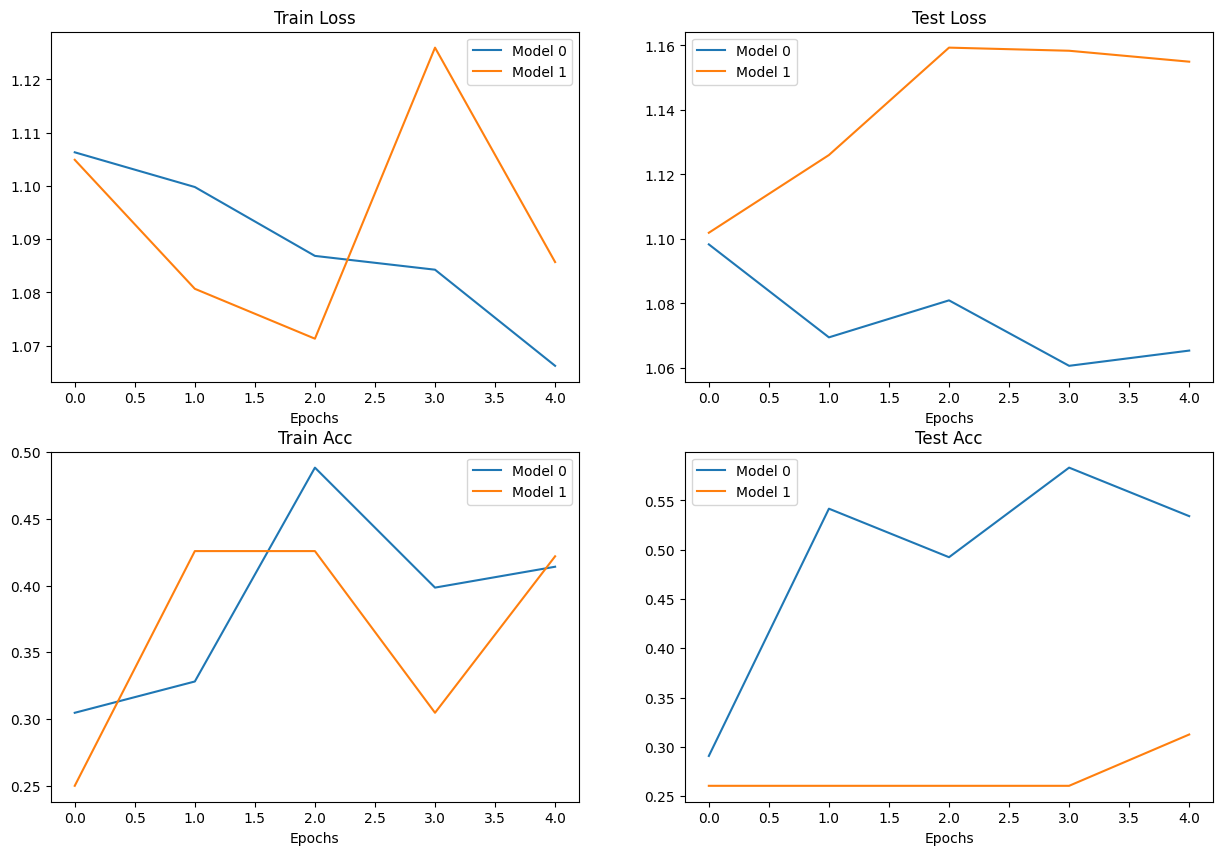

In [61]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();